In [ ]:
# STEP 1: Install Kaggle API and import necessary libraries
!pip install -q kaggle
import os
import zipfile

# STEP 2: Create the Kaggle directory and upload kaggle.json (already done by you)
kaggle_path = "/root/.kaggle"
os.makedirs(kaggle_path, exist_ok=True)
# If not uploaded, you'd use:
# from google.colab import files
# files.upload()  # upload kaggle.json manually here

# STEP 3: Move kaggle.json to the correct directory
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# STEP 4: Download the dataset from Kaggle
!kaggle datasets download -d debeshjha1/kvasirseg

# STEP 5: Unzip the dataset
with zipfile.ZipFile("kvasirseg.zip", 'r') as zip_ref:
    zip_ref.extractall("kvasirseg")

# STEP 6: Verify the extracted contents
import os
base_path = "kvasirseg/Kvasir-SEG"
for root, dirs, files in os.walk(base_path):
    print(f"{root}: {len(files)} files")


Dataset URL: https://www.kaggle.com/datasets/debeshjha1/kvasirseg
License(s): copyright-authors
 88% 127M/144M [00:00<00:00, 1.32GB/s]
100% 144M/144M [00:00<00:00, 1.26GB/s]
kvasirseg/Kvasir-SEG: 0 files
kvasirseg/Kvasir-SEG/Kvasir-SEG: 1 files
kvasirseg/Kvasir-SEG/Kvasir-SEG/images: 1000 files
kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images: 1000 files
kvasirseg/Kvasir-SEG/Kvasir-SEG/bbox: 1000 files
kvasirseg/Kvasir-SEG/Kvasir-SEG/masks: 1000 files


In [ ]:
import os
import pandas as pd
from PIL import Image
import shutil
import random

# Set paths
base_dir = "/content/kvasirseg/Kvasir-SEG/Kvasir-SEG"
images_dir = os.path.join(base_dir, "images")
bbox_dir = os.path.join(base_dir, "bbox")

# Output folders
output_dir = "kvasir_yolo"
images_output = os.path.join(output_dir, "images")
labels_output = os.path.join(output_dir, "labels")

for folder in ["train", "val", "test"]:
    os.makedirs(os.path.join(images_output, folder), exist_ok=True)
    os.makedirs(os.path.join(labels_output, folder), exist_ok=True)

# Helper to convert to YOLO format
def convert_bbox(xmin, ymin, xmax, ymax, img_w, img_h):
    x_center = (xmin + xmax) / 2 / img_w
    y_center = (ymin + ymax) / 2 / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    return [x_center, y_center, width, height]

# Prepare dataset list
all_files = [f for f in os.listdir(bbox_dir) if f.endswith(".csv")]
random.shuffle(all_files)

# Split into 70% train, 15% val, 15% test
total = len(all_files)
train_split = int(total * 0.7)
val_split = int(total * 0.85)

train_files = all_files[:train_split]
val_files = all_files[train_split:val_split]
test_files = all_files[val_split:]

def process_files(file_list, split):
    for csv_file in file_list:
        image_id = csv_file.replace(".csv", "")
        image_path = os.path.join(images_dir, image_id + ".jpg")
        label_path = os.path.join(labels_output, split, image_id + ".txt")

        if not os.path.exists(image_path):
            continue

        # Load image
        with Image.open(image_path) as img:
            w, h = img.size

        # Read bbox CSV
        df = pd.read_csv(os.path.join(bbox_dir, csv_file))

        # Write YOLO txt label
        with open(label_path, "w") as f:
            for _, row in df.iterrows():
                if row['class_name'].lower() != 'polyp':
                    continue
                xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
                x_center, y_center, width, height = convert_bbox(xmin, ymin, xmax, ymax, w, h)
                f.write(f"0 {x_center} {y_center} {width} {height}\n")

        # Copy image
        shutil.copy(image_path, os.path.join(images_output, split, image_id + ".jpg"))

# Process each split
process_files(train_files, "train")
process_files(val_files, "val")
process_files(test_files, "test")

# Create data.yaml (Note: test isn't used in YOLOv5 training, only for eval manually)
yaml_text = f"""
path: {os.path.abspath(output_dir)}
train: images/train
val: images/val

nc: 1
names: ['polyp']
"""

with open(os.path.join(output_dir, "data.yaml"), "w") as f:
    f.write(yaml_text.strip())

print("✅ YOLO dataset with train, val, and test prepared successfully!")


✅ YOLO dataset with train, val, and test prepared successfully!


In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17496, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 17496 (delta 2), reused 0 (delta 0), pack-reused 17491 (from 3)
Receiving objects: 100% (17496/17496), 16.59 MiB | 30.02 MiB/s, done.
Resolving deltas: 100% (11993/11993), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00

In [ ]:
import os
os.environ['WANDB_MODE'] = 'disabled'
os.environ['WANDB_DISABLED'] = 'true'


In [ ]:
custom_yolo_arch = '''# YOLOv5s Custom Model
nc: 1
depth_multiple: 0.33
width_multiple: 0.50

anchors:
  - [10,13, 16,30, 33,23]
  - [30,61, 62,45, 59,119]
  - [116,90, 156,198, 373,326]

backbone:
  [
    [ -1, 1, Focus, [64, 3] ],
    [ -1, 1, Conv, [128, 3, 2] ],
    [ -1, 3, BottleneckCSP, [128] ],
    [ -1, 1, Conv, [256, 3, 2] ],
    [ -1, 9, BottleneckCSP, [256] ],
    [ -1, 1, Conv, [512, 3, 2] ],
    [ -1, 9, BottleneckCSP, [512] ],
    [ -1, 1, Conv, [1024, 3, 2] ],
    [ -1, 1, SPP, [1024, [5, 9, 13]] ],
    [ -1, 3, BottleneckCSP, [1024, False] ]
  ]

head:
  [
    [ -1, 1, Conv, [512, 1, 1] ],
    [ -1, 1, nn.Upsample, [None, 2, 'nearest'] ],
    [ [ -1, 6 ], 1, Concat, [1] ],
    [ -1, 3, BottleneckCSP, [512] ],

    [ -1, 1, Conv, [256, 1, 1] ],
    [ -1, 1, nn.Upsample, [None, 2, 'nearest'] ],
    [ [ -1, 4 ], 1, Concat, [1] ],
    [ -1, 3, BottleneckCSP, [256] ],

    [ -1, 1, Conv, [256, 3, 2] ],
    [ [ -1, 14 ], 1, Concat, [1] ],
    [ -1, 3, BottleneckCSP, [512] ],

    [ -1, 1, Conv, [512, 3, 2] ],
    [ [ -1, 10 ], 1, Concat, [1] ],
    [ -1, 3, BottleneckCSP, [1024] ],

    [ [17, 20, 23], 1, Detect, [nc, anchors] ]
  ]
'''

with open('/content/yolov5/models/mycustom_yolov5s.yaml', 'w') as f:
    f.write(custom_yolo_arch.strip())


In [ ]:
import os
os.environ['WANDB_MODE'] = 'dryrun'


In [ ]:
hyp_path = "/content/yolov5/data/hyps/thyp.scratch-med.yaml"

hyp_text = """
lr0: 0.001
lrf: 0.01
momentum: 0.937
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.8
warmup_bias_lr: 0.1
box: 0.05
cls: 0.3
cls_pw: 1.0
obj: 1.0
obj_pw: 1.0
iou_t: 0.2
anchor_t: 4.0
fl_gamma: 0.0
hsv_h: 0.015
hsv_s: 0.4
hsv_v: 0.3
degrees: 0.0
translate: 0.05
scale: 0.4
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.3
mosaic: 1.0
mixup: 0.0
copy_paste: 0.0
"""

with open(hyp_path, "w") as f:
    f.write(hyp_text.strip())

print("✅ Saved custom hyp.scratch-med.yaml")


✅ Saved custom hyp.scratch-med.yaml


In [ ]:
!python train.py \
  --img 640 \
  --batch 16 \
  --epochs 100 \
  --data /content/kvasir_yolo/data.yaml \
  --cfg /content/yolov5/models/mycustom_yolov5s.yaml \
  --weights yolov5s.pt \
  --name custom_yolov5s_med \
  --project runs/train \
  --optimizer Adam \
  --hyp /content/yolov5/data/hyps/thyp.scratch-med.yaml \
  --device 0 \
  --exist-ok \
  --workers 0


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-07-01 09:02:00.524025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751360520.544839   17542 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751360520.550924   17542 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: WARNING Unable to verify login in offline mode.
train: weights=yolov5s.pt, cfg=/content/yolov5/models/mycustom_yolov5s.yaml, data=/content/kvasir_yolo/data.yaml, hyp=/content/yolov5/data/hyps/thyp.scratch-med.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resu

In [ ]:
!python val.py \
  --data /content/kvasir_yolo/data.yaml \
  --weights "/content/final_best .pt" \
  --task test \
  --save-txt \
  --save-conf \
  --save-hybrid \
  --project runs/val \
  --name reval_custom \
  --exist-ok


val: data=/content/kvasir_yolo/data.yaml, weights=['/content/final_best .pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=True, save_conf=True, save_json=False, project=runs/val, name=reval_custom, exist_ok=True, half=False, dnn=False
WARNING ⚠️ --save-hybrid will return high mAP from hybrid labels, not from predictions alone
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
mycustom_YOLOv5s summary: 182 layers, 7246518 parameters, 0 gradients
test: Scanning /content/kvasir_yolo/labels/test.cache... 150 images, 0 backgrounds, 0 corrupt: 100% 150/150 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 5/5 [00:04<00:00,  1.07it/s]
                   all        150        172          1          1      0.995      0.995
Speed: 0.2ms pre-proc

In [ ]:
!python val.py \
  --data /content/kvasir_yolo/data.yaml \
  --weights "/content/final_best.pt" \
  --task test \
  --save-txt \
  --save-conf \
  --save-hybrid \
  --project runs/val \
  --name reval_custom \
  --exist-ok


val: data=/content/kvasir_yolo/data.yaml, weights=['/content/final_best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=True, save_conf=True, save_json=False, project=runs/val, name=reval_custom, exist_ok=True, half=False, dnn=False
WARNING ⚠️ --save-hybrid will return high mAP from hybrid labels, not from predictions alone
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Traceback (most recent call last):
  File "/content/yolov5/val.py", line 604, in <module>
    main(opt)
  File "/content/yolov5/val.py", line 575, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/content/yolov5/val.py", line 270, in run
    model = DetectMultiBackend(weights, device=de

In [ ]:
!python detect.py \
  --weights /content/final_best.pt \
  --source /content/kvasir_yolo/images/test \
  --img 640 \
  --conf 0.25 \
  --save-txt \
  --save-conf \
  --project runs/predict \
  --name custom_pred \
  --exist-ok


detect: weights=['/content/final_best.pt'], source=/content/kvasir_yolo/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict, name=custom_pred, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 438, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 433, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/content/yolov5/detect.py", li

In [ ]:
import os
!ls -l /content | grep pt


-rw-r--r--  1 root root  14922052 Jul  1 10:34 final_best .pt


In [ ]:
!mv "/content/final_best .pt" "/content/final_best.pt"


In [ ]:
!python detect.py \
  --weights /content/final_best.pt \
  --source /content/kvasir_yolo/images/test \
  --img 640 \
  --conf 0.25 \
  --save-txt \
  --save-conf \
  --project runs/predict \
  --name custom_pred \
  --exist-ok


detect: weights=['/content/final_best.pt'], source=/content/kvasir_yolo/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict, name=custom_pred, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
mycustom_YOLOv5s summary: 182 layers, 7246518 parameters, 0 gradients
image 1/150 /content/kvasir_yolo/images/test/cju0sr5ghl0nd08789uzf1raf.jpg: 544x640 2 polyps, 30.4ms
image 2/150 /content/kvasir_yolo/images/test/cju0t4oil7vzk099370nun5h9.jpg: 576x640 1 polyp, 29.6ms
image 3/150 /content/kvasir_yolo/images/test/cju13cgqmnhwn0988yrainhcp.jpg: 576x640 1 polyp, 12.1ms
imag

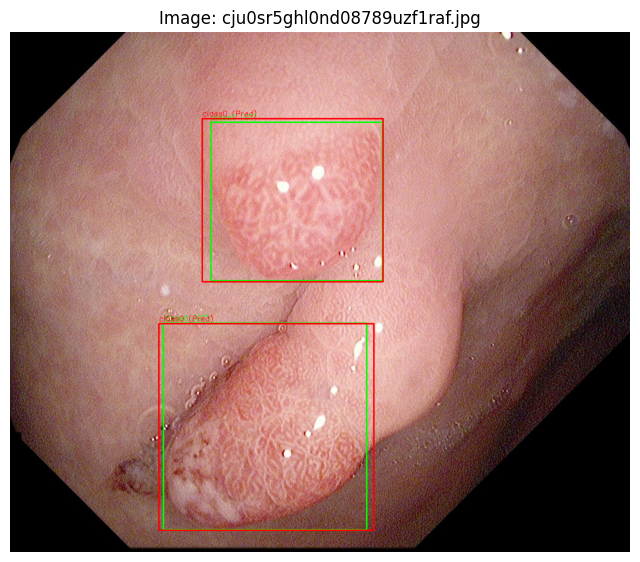

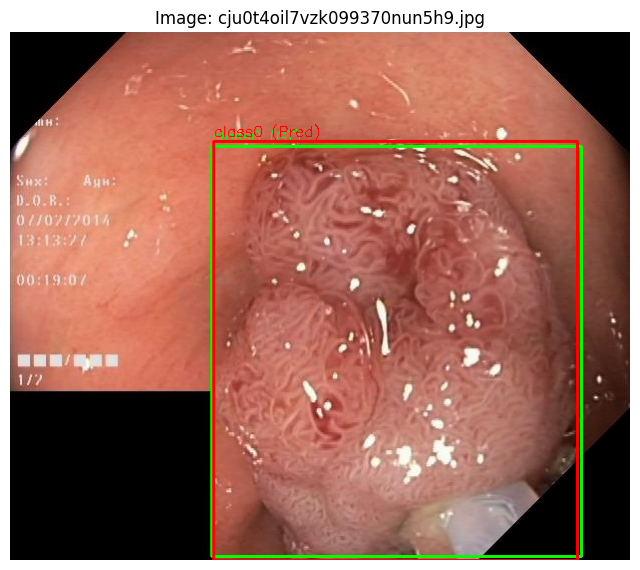

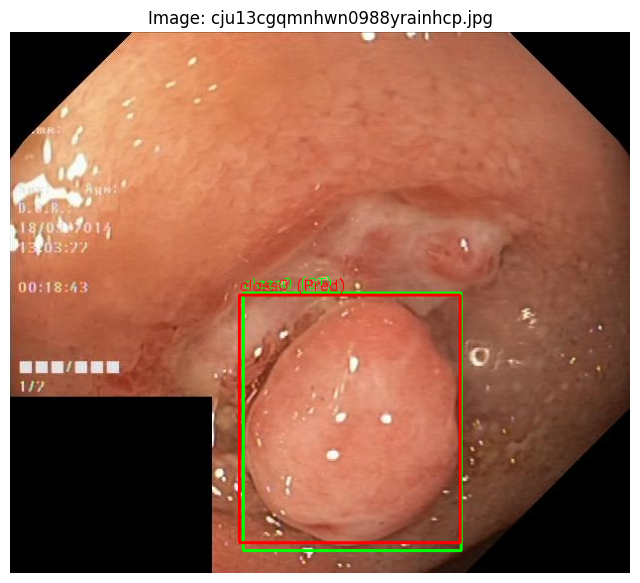

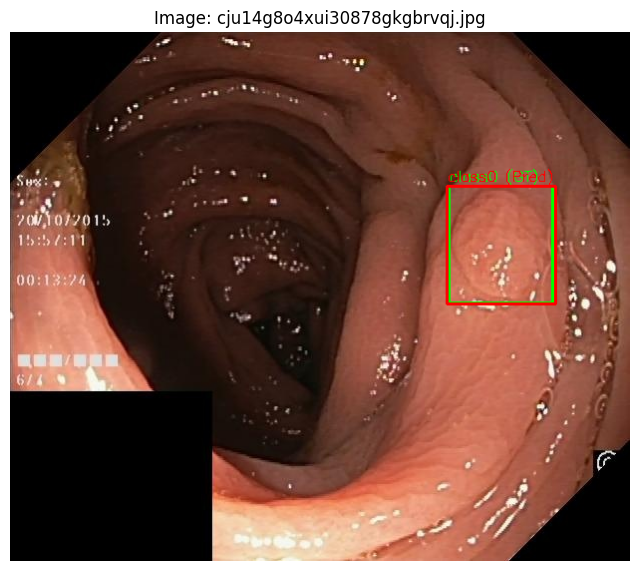

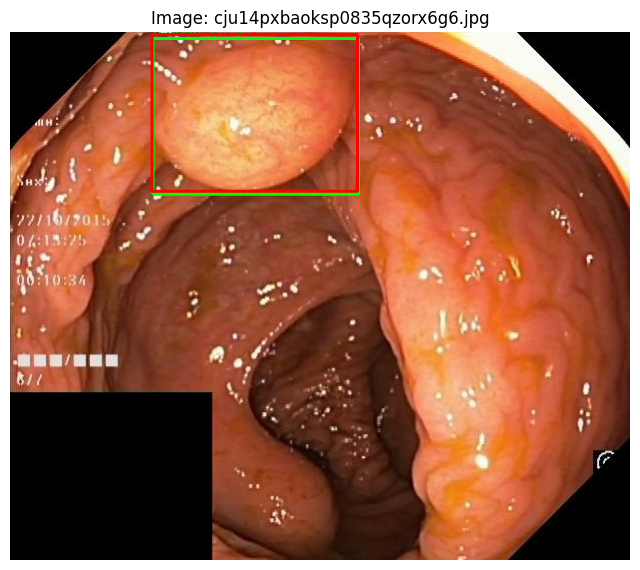

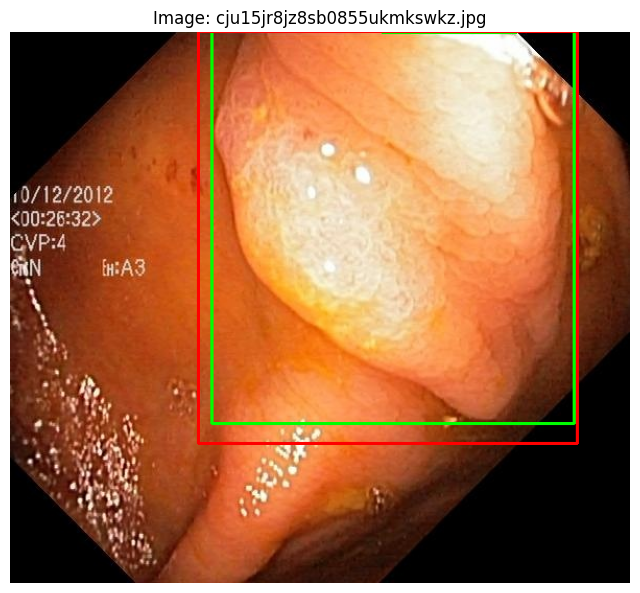

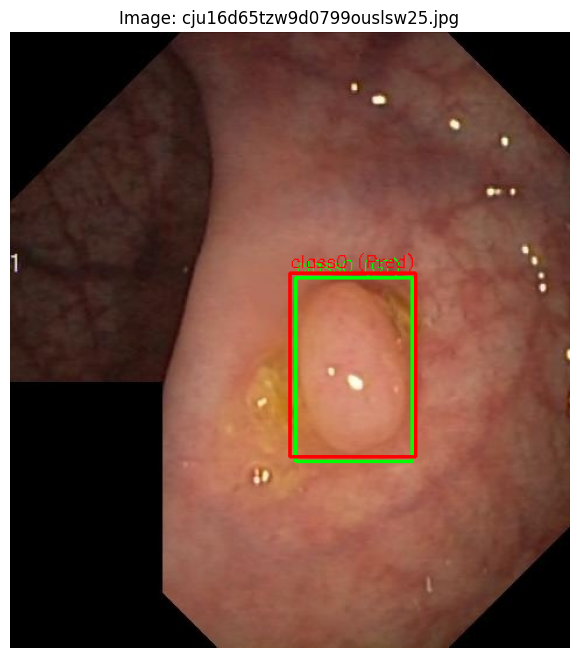

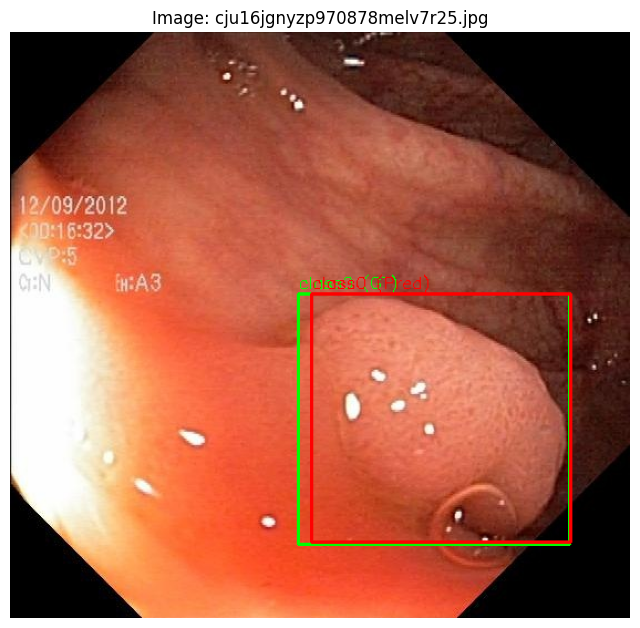

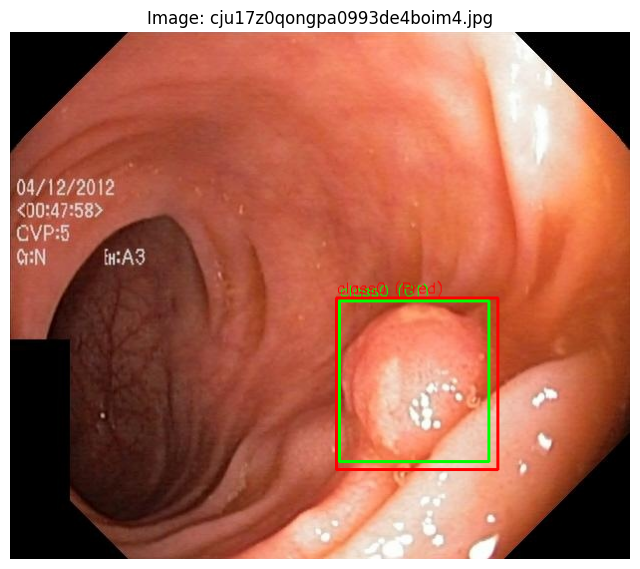

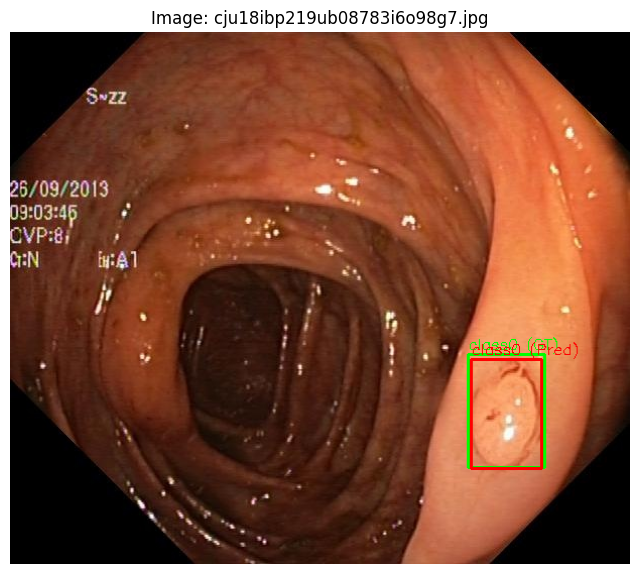

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Set paths
test_img_dir = "/content/kvasir_yolo/images/test"
gt_label_dir = "/content/kvasir_yolo/labels/test"
pred_label_dir = "/content/yolov5/runs/predict/custom_pred/labels"
class_names = ['class0', 'class1']  # Replace with your actual class names

def draw_boxes(img, label_path, color, label_type='GT'):
    if not os.path.exists(label_path):
        return img

    h, w = img.shape[:2]
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls, x, y, bw, bh = map(float, parts[:5])
            x1 = int((x - bw / 2) * w)
            y1 = int((y - bh / 2) * h)
            x2 = int((x + bw / 2) * w)
            y2 = int((y + bh / 2) * h)
            label = class_names[int(cls)] if int(cls) < len(class_names) else str(int(cls))
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, f"{label} ({label_type})", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return img

# Show a few images with GT and Predictions
img_files = sorted(os.listdir(test_img_dir))[:10]  # View first 10

for file in img_files:
    base = os.path.splitext(file)[0]
    img_path = os.path.join(test_img_dir, file)
    gt_path = os.path.join(gt_label_dir, base + '.txt')
    pred_path = os.path.join(pred_label_dir, base + '.txt')

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gt = draw_boxes(img.copy(), gt_path, (0, 255, 0), 'GT')       # Green = GT
    img_pred = draw_boxes(img_gt, pred_path, (255, 0, 0), 'Pred')     # Red = Prediction

    plt.figure(figsize=(8, 8))
    plt.imshow(img_pred)
    plt.title(f"Image: {file}")
    plt.axis("off")
    plt.show()
